# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

import numpy as np
import pandas as pd

import datetime
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, MinMaxScaler, Normalizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
# create a Spark session

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('SparkFeatures') \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

#### Load Dataset

In [3]:
# load dataset
spark_df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
spark_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
spark_df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [6]:
spark_df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

#### Check for missing values

In [4]:
# missing values

# source: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

def count_missing_values(spark_df, sort_df=True):
    """
    Count number of null and nan values in each column of the DataFrame spark_df
    """
    
    df = spark_df.select([count(when(isnan(c) | isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes]).toPandas()
  #  df = spark_df.select([count(when(isnan(c) | isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()
    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort_df:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df



In [5]:
count_missing_values(spark_df)

,count
artist,58392
length,58392
song,58392
firstName,8346
gender,8346
userAgent,8346
lastName,8346
location,8346
registration,8346
sessionId,0


In [6]:
count_missing_values(spark_df, sort_df = False)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [7]:
# find missing user ids

In [8]:
spark_df.select('*').where(col('userId').isNull()).count()

0

In [9]:
spark_df.select("userId").where(col("userId")=='').count()

8346

In [10]:
spark_df.where(spark_df.userId == '').show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [11]:
spark_df.where(spark_df.userId == '').where(spark_df.auth == 'Logged Out').count()

8249

In [12]:
spark_df.select('auth').groupby('auth').count().collect()

[Row(auth='Logged Out', count=8249),
 Row(auth='Cancelled', count=52),
 Row(auth='Guest', count=97),
 Row(auth='Logged In', count=278102)]

In [13]:
spark_df.where(spark_df.userId == '').where(spark_df.auth == 'Guest').count()

97

Based on a first investigation of missing data, we can asume, that User Ids are only empty if users are 'logged out' or are 'guest'-users

In the next step, we take a look at missing values in the session id


In [14]:
# find missing session id

In [15]:
spark_df.select("sessionId").where(col("sessionId")=='').count()

0

In the smaller subset of data there no empty session ids.

#### Data Cleaning

In [16]:
#remove rows with empty User Ids
spark_df = spark_df.where(spark_df.userId != '')

In [17]:
# check for duplicated data
duplicates = spark_df.dropDuplicates()
print(spark_df.count() - duplicates.count())

0


No duplicates in this dataset

In [18]:
# convert timestamps

#timestamp data in columns 'ts' and ' registration'

spark_df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [19]:
#datetime.datetime.fromtimestamp(1538352117000)

In [20]:
datetime.datetime.fromtimestamp(1538352117000/1000)

datetime.datetime(2018, 10, 1, 0, 1, 57)

In [21]:
convert_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [22]:
spark_df = spark_df.withColumn('timestamp', convert_timestamp(spark_df.ts))

spark_df = spark_df.withColumn('registration_timestamp', convert_timestamp(spark_df.registration))

In [23]:
spark_df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57', registration_timestamp='2018-09-28 22:22:42')

In [3]:
# summarize above steps for data cleaning in one funciton:

def clean_dataset(df):
    '''
    Function for  for data cleaning
    INPUT:
    df - initial dataset
    
    OUTPUT:
    df - clean dataset for further processing 
    '''
        
    #remove rows with empty User Ids
    df = df.where(df.userId != '')
    
    #convert timestamps
    convert_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    
    df = df.withColumn('timestamp', convert_timestamp(df.ts))
    df = df.withColumn('registration_timestamp', convert_timestamp(df.registration))
    
    return df
    

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
# Define Churn

pages = spark_df.select('page').dropDuplicates()
page_names = pages.toPandas()

page_names = page_names['page'].tolist()

In [40]:
for page in page_names:
    print(page)

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Settings
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade


In [27]:
spark_df.groupby(['page']).agg(count('page')).sort(desc('count(page)')).show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



In [28]:
spark_df.groupby(['page']).agg(count('page')).sort(asc('count(page)')).show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|Cancellation Conf...|         52|
|    Submit Downgrade|         63|
|      Submit Upgrade|        159|
|               Error|        252|
|       Save Settings|        310|
|               About|        495|
|             Upgrade|        499|
|                Help|       1454|
|            Settings|       1514|
|           Downgrade|       2055|
|         Thumbs Down|       2546|
|              Logout|       3226|
|         Roll Advert|       3933|
|          Add Friend|       4277|
|     Add to Playlist|       6526|
|                Home|      10082|
|           Thumbs Up|      12551|
|            NextSong|     228108|
+--------------------+-----------+



In [29]:
#define churn as 'cancellation confirmation'

churn = spark_df.filter(spark_df.page=='Cancellation Confirmation').select('userId').dropDuplicates()

In [30]:
churn.show()

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
+------+
only showing top 20 rows



In [31]:
churn_users = [(row['userId']) for row in churn.collect()]
churn_df = spark_df.withColumn('churn', spark_df.userId.isin(churn_users))

In [32]:
churn_df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|          timestamp|registration_timestamp|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockp

In [33]:
churn_df.select(['userId', 'page', 'timestamp', 'level', 'song', 'sessionId', 'length', 'churn']).where(churn_df.userId == '51').sort('timestamp').show(50)

+------+---------------+-------------------+-----+--------------------+---------+---------+-----+
|userId|           page|          timestamp|level|                song|sessionId|   length|churn|
+------+---------------+-------------------+-----+--------------------+---------+---------+-----+
|    51|           Home|2018-10-01 12:57:12| paid|                null|      236|     null| true|
|    51|       NextSong|2018-10-01 12:57:29| paid|         Window Seat|      236|289.69751| true|
|    51|       NextSong|2018-10-01 13:02:18| paid|       Niets Dan Dit|      236|229.82485| true|
|    51|       NextSong|2018-10-01 13:06:07| paid|               Horny|      236|184.29342| true|
|    51|       NextSong|2018-10-01 13:09:11| paid|Me and Your Cigar...|      236|144.14322| true|
|    51|       NextSong|2018-10-01 13:11:35| paid|                Undo|      236|348.57751| true|
|    51|       NextSong|2018-10-01 13:17:23| paid|   Anywhere But Here|      236|243.04281| true|
|    51|       NextS

In [34]:
churn_df.select(['timestamp', 'userId', 'gender', 'level', 'sessionId', 'page', 'song', 'artist', 'length']).where(churn_df.userId == '51').sort('timestamp').show(50)

+-------------------+------+------+-----+---------+---------------+--------------------+--------------------+---------+
|          timestamp|userId|gender|level|sessionId|           page|                song|              artist|   length|
+-------------------+------+------+-----+---------+---------------+--------------------+--------------------+---------+
|2018-10-01 12:57:12|    51|     M| paid|      236|           Home|                null|                null|     null|
|2018-10-01 12:57:29|    51|     M| paid|      236|       NextSong|         Window Seat|         Erykah Badu|289.69751|
|2018-10-01 13:02:18|    51|     M| paid|      236|       NextSong|       Niets Dan Dit|             BlÃÂ¸f|229.82485|
|2018-10-01 13:06:07|    51|     M| paid|      236|       NextSong|               Horny|Mousse T. Vs Hot ...|184.29342|
|2018-10-01 13:09:11|    51|     M| paid|      236|       NextSong|Me and Your Cigar...|     Miranda Lambert|144.14322|
|2018-10-01 13:11:35|    51|     M| paid

#### Explore Data

behavior for users who stayed vs users who churned
exploring aggregates on these two groups of users
observing how much of a specific action they experienced per a certain time unit
number of songs played.

- gender
- paid vs free
- session duration
- number of songs per session
- thumbs down
- next song
- settings

In [35]:
# transform spark DataFrame to Pandas DataFrame for visualization

df_churn = churn_df.toPandas()

df_churn_t = churn_df.where(churn_df.churn == True)
df_churn_f = churn_df.where(churn_df.churn == False)

df_t = df_churn_t.toPandas()
df_f = df_churn_f.toPandas()


In [36]:
churn_true = df_churn_t.groupBy('userId').count().count()
churn_false = df_churn_f.groupBy('userId').count().count()

print('Number of churned users:{}'.format(churn_true))
print('Number of non churned users:{}'.format(churn_false))

Number of churned users:52
Number of non churned users:173


In [40]:
df_churn.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,timestamp,registration_timestamp,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,2018-09-28 22:22:42,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,2018-09-30 18:20:30,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,2018-09-28 22:22:42,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,2018-09-30 18:20:30,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,2018-09-28 22:22:42,False


In [41]:
df_churn_gender = churn_df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn').toPandas()

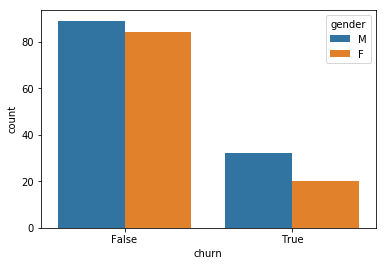

In [42]:
sns.barplot(x='churn', y='count', hue='gender', data=df_churn_gender)

In [43]:
df_churn_level = churn_df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().sort('churn').toPandas()

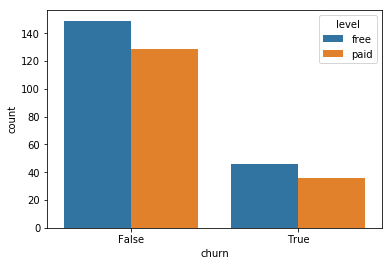

In [44]:
sns.barplot(x='churn', y='count', hue='level', data=df_churn_level)

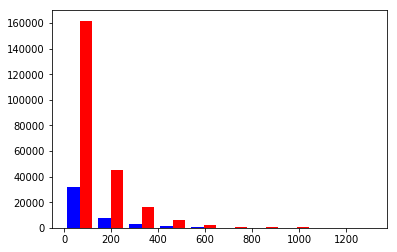

In [45]:
plt.hist([df_t.itemInSession, df_f.itemInSession], color=['blue','red']);


In [46]:
df_test = df_t.groupby(by=('sessionId', 'userId'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [47]:
df_test.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,timestamp,registration_timestamp,churn
0,Modjo,Logged In,Alexi,F,0,Warren,250.93179,paid,"Spokane-Spokane Valley, WA",PUT,...,1532482662000,53,What I Mean,200,1538353930000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,2018-10-01 00:32:10,2018-07-25 01:37:42,True
1,Edwyn Collins,Logged In,Alexi,F,1,Warren,216.84200,paid,"Spokane-Spokane Valley, WA",PUT,...,1532482662000,53,You'll Never Know (My Love) (Bovellian 07 Mix),200,1538354180000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,2018-10-01 00:36:20,2018-07-25 01:37:42,True
2,Coldplay,Logged In,Alexi,F,2,Warren,343.32689,paid,"Spokane-Spokane Valley, WA",PUT,...,1532482662000,53,For You,200,1538354396000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,2018-10-01 00:39:56,2018-07-25 01:37:42,True
3,Kix,Logged In,Alexi,F,3,Warren,246.25587,paid,"Spokane-Spokane Valley, WA",PUT,...,1532482662000,53,Girl Money,200,1538354739000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,2018-10-01 00:45:39,2018-07-25 01:37:42,True
4,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,...,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54,2018-10-01 00:45:49,2018-07-25 01:37:42,True
8,None,Logged In,Alex,M,1,Hogan,NaN,free,"Denver-Aurora-Lakewood, CO",GET,...,1535066380000,100,None,200,1538358605000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,2018-10-01 01:50:05,2018-08-23 23:19:40,True
9,The Cardigans,Logged In,Alex,M,2,Hogan,198.21669,free,"Denver-Aurora-Lakewood, CO",PUT,...,1535066380000,100,Lovefool,200,1538358818000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,2018-10-01 01:53:38,2018-08-23 23:19:40,True
10,Collective Soul,Logged In,Alex,M,3,Hogan,273.47546,free,"Denver-Aurora-Lakewood, CO",PUT,...,1535066380000,100,Run (LP Version),200,1538359016000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,2018-10-01 01:56:56,2018-08-23 23:19:40,True
11,Dario Marianelli,Logged In,Alex,M,4,Hogan,146.99057,free,"Denver-Aurora-Lakewood, CO",PUT,...,1535066380000,100,Cello Lesson,200,1538359289000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,2018-10-01 02:01:29,2018-08-23 23:19:40,True
12,David Sanborn,Logged In,Alex,M,5,Hogan,217.73016,free,"Denver-Aurora-Lakewood, CO",PUT,...,1535066380000,100,Little Flower,200,1538359435000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101,2018-10-01 02:03:55,2018-08-23 23:19:40,True


In [48]:
# thumbs down per session

df_churn_t_thumbsdown = df_churn_t.filter(df_churn_t.page == 'Thumbs Down')
df_churn_t_thumbsdown = df_churn_t_thumbsdown.groupby(df_churn_t.sessionId).count()
df_churn_t_thumbsdown = df_churn_t_thumbsdown.orderBy(df_churn_t.sessionId.cast("float")) 
df_churn_t_thumbsdown = df_churn_t_thumbsdown.withColumnRenamed('count', 'Thumbs Down churn')

df_churn_f_thumbsdown = df_churn_f.filter(df_churn_f.page == 'Thumbs Down')
df_churn_f_thumbsdown = df_churn_f_thumbsdown.groupby(df_churn_f.sessionId).count()
df_churn_f_thumbsdown = df_churn_f_thumbsdown.orderBy(df_churn_f.sessionId.cast("float")) 
df_churn_f_thumbsdown = df_churn_f_thumbsdown.withColumnRenamed('count', 'Thumbs Down non_churn')
        
df_churn_thumbsdown_spark = df_churn_t_thumbsdown.join(df_churn_f_thumbsdown, how='left', on='sessionId')
df_churn_thumbsdown_pd = df_churn_thumbsdown_spark.drop('sessionId').toPandas()

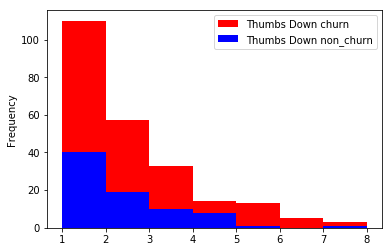

In [49]:
df_churn_thumbsdown_pd.plot(kind='hist', color=['red','blue'], bins = 7);

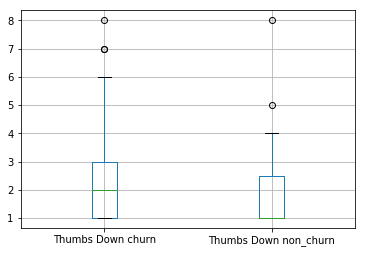

In [50]:
df_churn_thumbsdown_pd.boxplot();

Users who use more thumbs down per session are more likely to churn

In the next step, we look at the number of page visits per type per session for each userId

In [4]:
def sum_per_session(df_churn, df_non_churn, page_name):
    '''
    Function which summarizes page visits per session of churn and non_churn dataset.
    
    INPUT: 
    df_churn - dataframe containing Sparkify log events for curned users
    df_non_churn - dataframe containing Sparkify log events for non curned users
    page_name - name of page
    
    
    OUTPUT:
    df_churn_spark
    df_churn_pd 
    
    '''
    df_churn_page = df_churn.filter(df_churn.page == page_name)
    df_churn_page = df_churn_page.groupby(df_churn_page.sessionId).count()
    df_churn_page = df_churn_page.orderBy(df_churn_page.sessionId.cast("float")) 
    df_churn_page = df_churn_page.withColumnRenamed('count', page_name + '_churn')
    
    df_non_churn_page = df_non_churn.filter(df_non_churn.page == page_name)
    df_non_churn_page = df_non_churn_page.groupby(df_non_churn_page.sessionId).count()
    df_non_churn_page = df_non_churn_page.orderBy(df_non_churn_page.sessionId.cast("float")) 
    df_non_churn_page = df_non_churn_page.withColumnRenamed('count', page_name + '_non_churn')

    df_churn_spark = df_churn_page.join(df_non_churn_page, how='left', on='sessionId')
    df_churn_pd = df_churn_spark.drop('sessionId').toPandas()
    
    return df_churn_spark, df_churn_pd    

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Settings
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade


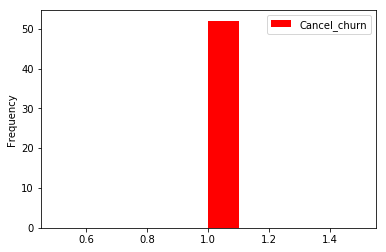

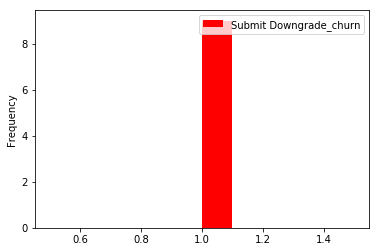

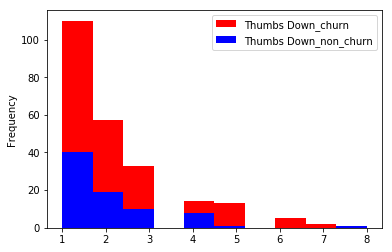

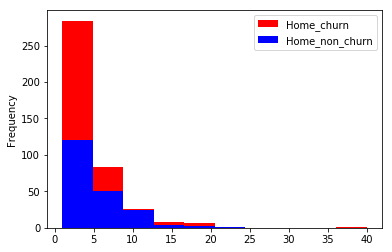

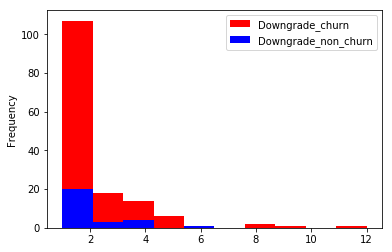

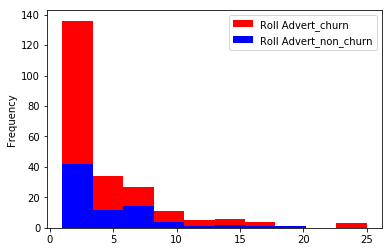

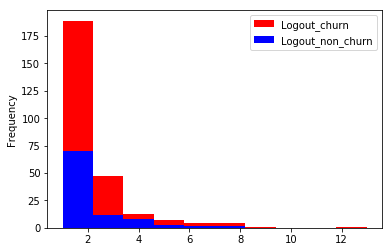

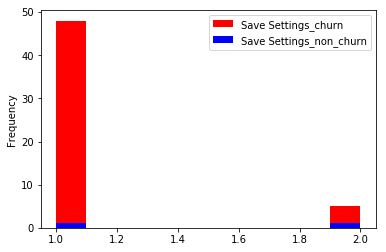

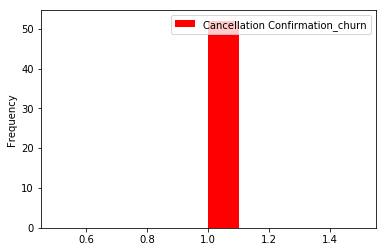

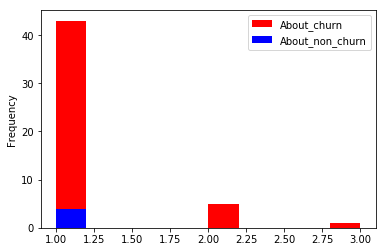

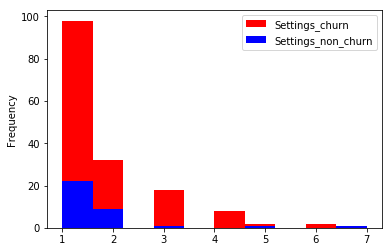

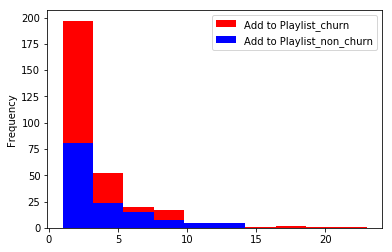

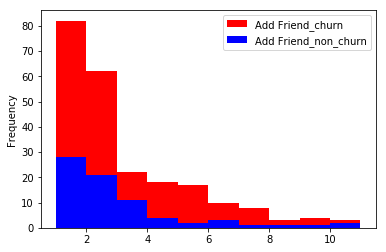

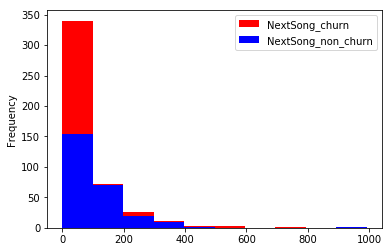

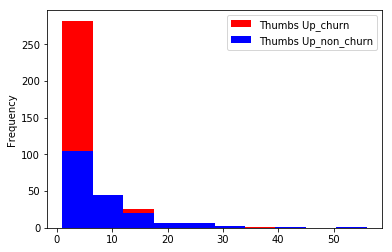

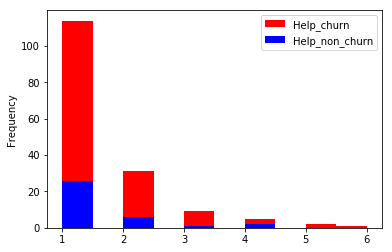

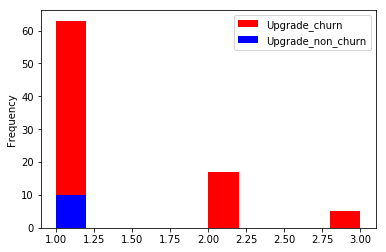

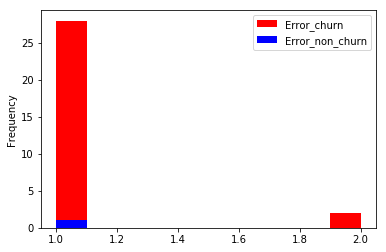

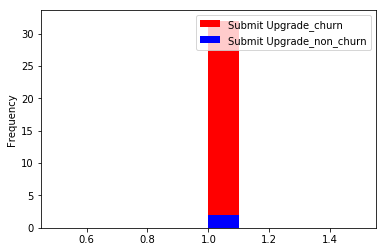

In [52]:
for page in page_names:
    print(page)
    
    sp, pd = sum_per_session(df_churn_t, df_churn_f, page)
    
    pd.plot(kind='hist', color=['red','blue']);   

It seems that the following features could have an impact, in weather a user will churn or not:
* gender
* songs played
* events 
* thumbs up
* thumbs down
* add friend

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the findings of the above analyses, we will use the following features for classification in the remaining part of the project:

* gender
* songs played
* events 
* thumbs up
* thumbs down
* add friend

In [5]:
def extract_features(df):
    '''
    Script to prepare dataset and extract the necessary features from the dataset
    
    INPUT:
    df - initial raw dataset
    
    OUTPUT:
    df - processed initial dataset
    df_features - prepared final dataset containing features and labels
    
    '''
    
    
    # data cleaning with above function    
    df = clean_dataset(df)   
    
    #define churn and add to dataset
    churn = df.filter(df.page=='Cancellation Confirmation').select('userId').dropDuplicates()    
    churn_users = [(row['userId']) for row in churn.collect()]    
    #df = df.withColumn('churn', df.userId.isin(churn_users))
    true_churn = udf(lambda x: 1 if x in churn_users else 0, IntegerType())
    
    df = df.withColumn('label', true_churn('userId'))
    
    convert_timestamp_to_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))      
    
    # create column date
    df = df.withColumn('date', convert_timestamp_to_date(df.ts))
    
    # create column songs_per_day with avergage number of songs played by user   
    w = Window.partitionBy('userId', 'date')
    avg_songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('avg_songs')).distinct()
    w = Window.partitionBy('userId')
    avg_songs = avg_songs.withColumn('songs_per_day', avg('avg_songs').over(w))
    avg_songs = avg_songs.select(col('userId').alias('songs_per_userId'), 'songs_per_day')
    avg_songs = avg_songs.withColumn('songs_per_day', round(avg_songs['songs_per_day'], 2))
    
    # create column events_per_day with avergage number of events by user   
    w = Window.partitionBy('userId', 'date')
    avg_events = df.select('userId', 'date', count('userId').over(w).alias('avg_events')).distinct()
    w = Window.partitionBy('userId')
    avg_events = avg_events.withColumn('events_per_day', avg('avg_events').over(w))
    avg_events = avg_events.select(col('userId').alias('events_per_userId'), 'events_per_day')
    avg_events = avg_events.withColumn('events_per_day', round(avg_events['events_per_day'], 2))
    
    # create columns for number of 'thumbs up' anbd 'thumbs down' per user
    w = Window.partitionBy('userId')    
    thumbs_up = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbs_up = thumbs_up.select(col('userId').alias('thumbs_up_userId'), 'thumbs_up')
    thumbs_down = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbs_down = thumbs_down.select(col('userId').alias('thumbs_down_userId'), 'thumbs_down')
    
    # create columb for number of added friends per user
    
    w = Window.partitionBy('userId')
    add_friend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('add_friend')).distinct()
    add_friend = add_friend.select(col('userId').alias('add_friend_userId'), 'add_friend')
    
    
    # create final dataset
    
    df_features = df.select(['userId', 'gender', 'page', 'timestamp', 'level', 'song', 'sessionId', 'length', 'label']).dropna().drop_duplicates()
    
    df_features = df_features.join(avg_songs, df_features.userId == avg_songs.songs_per_userId).distinct()
    df_features = df_features.join(avg_events, df_features.userId == avg_events.events_per_userId).distinct()
    df_features = df_features.join(thumbs_up, df_features.userId == thumbs_up.thumbs_up_userId, how='left').distinct()
    df_features = df_features.join(thumbs_down, df_features.userId == thumbs_down.thumbs_down_userId, how='left').distinct()
    df_features = df_features.fillna(0, subset=['thumbs_up'])
    df_features = df_features.fillna(0, subset=['thumbs_down'])
    df_features = df_features.join(add_friend, df_features.userId == add_friend.add_friend_userId, how='left').distinct()
    df_features = df_features.fillna(0, subset=['add_friend'])
    df_features = df_features.drop('songs_per_userId', 'events_per_userId', 'thumbs_up_userId', 'thumbs_down_userId', 'add_friend_userId')

    
    return df, df_features   


In [6]:
# try script on dataset

df_new = spark.read.json('mini_sparkify_event_data.json')

df_processed, df_features = extract_features(df_new)

In [55]:
df_features.show()

+------+------+--------+-------------------+-----+--------------------+---------+---------+-----+-------------+--------------+---------+-----------+----------+
|userId|gender|    page|          timestamp|level|                song|sessionId|   length|label|songs_per_day|events_per_day|thumbs_up|thumbs_down|add_friend|
+------+------+--------+-------------------+-----+--------------------+---------+---------+-----+-------------+--------------+---------+-----------+----------+
|100010|     F|NextSong|2018-11-09 07:06:28| free|How I (Learned My...|      174|134.73914|    0|        39.29|         54.43|       17|          5|         4|
|100010|     F|NextSong|2018-11-05 11:00:13| free|       It's All Good|      133|181.10649|    0|        39.29|         54.43|       17|          5|         4|
|100010|     F|NextSong|2018-10-08 14:10:41| free|          Coma White|       31|338.18077|    0|        39.29|         54.43|       17|          5|         4|
|100010|     F|NextSong|2018-11-09 04:15

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Split clean Dataset into train, test and validation sets

In [7]:
# split into train, test and validation sets
# source: https://stackoverflow.com/questions/40293970/spark-data-frame-random-splitting#40295318

df = df_features
random_seed = 31

train, test_valid = df.randomSplit([0.8, 0.2], seed = random_seed)
test, valid = df.randomSplit([0.5, 0.5], seed = random_seed)



In [57]:
df.show()

+------+------+--------+-------------------+-----+--------------------+---------+---------+-----+-------------+--------------+---------+-----------+----------+
|userId|gender|    page|          timestamp|level|                song|sessionId|   length|label|songs_per_day|events_per_day|thumbs_up|thumbs_down|add_friend|
+------+------+--------+-------------------+-----+--------------------+---------+---------+-----+-------------+--------------+---------+-----------+----------+
|100010|     F|NextSong|2018-11-09 07:06:28| free|How I (Learned My...|      174|134.73914|    0|        39.29|         54.43|       17|          5|         4|
|100010|     F|NextSong|2018-11-05 11:00:13| free|       It's All Good|      133|181.10649|    0|        39.29|         54.43|       17|          5|         4|
|100010|     F|NextSong|2018-10-08 14:10:41| free|          Coma White|       31|338.18077|    0|        39.29|         54.43|       17|          5|         4|
|100010|     F|NextSong|2018-11-09 04:15

Since the goal is to classify, weather a user will churn or not, we will user three of the most common classifier models: Logistic Regression, Random Forest Classifier and the Gradient Boosted Tree Classifier

To validate and optimize our models, we will use the F1 metric, since the dataset contains largely unbalanced data of churned an non churned users

In [8]:
def model_train_and_summarize(model, train, test, features):
    '''
    Script to train selected model on train dataset and vaidate the results on train and test dataset
    
    INPUT:
    model - type of ml model (lr, rf, gbt)
    train - train data set
    test - test data set
    features - feature vector
    
    OUTPUT:
    model - trained ml model    
    '''
    
    # prepare parts of ml pipeline
    gender_indexer = StringIndexer(inputCol = 'gender', outputCol = 'gender_idx')
    assembler = VectorAssembler(inputCols= features, outputCol = 'features')
    NScaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaled_features')
    
    #define ml models
    lr = LogisticRegression(labelCol = 'label', fitIntercept = False, featuresCol = 'scaled_features', maxIter = 10, regParam=0.3, elasticNetParam = 0.8)
    rf = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', numTrees = 15)
    gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=7)
        
    if model == 'lr':
        model = lr
    elif model == 'rf':
        model = rf
    elif model == 'gbt':
        model = gbt
    else: print('Error: Undefined Model for training. Use lr, rf or gbt')
    
    #set up ml pipeline
    pipeline = Pipeline(stages=[gender_indexer, assembler, NScaler, model])
    
    #train model
    start_time = time.time()
    model = pipeline.fit(train)
    end_time = time.time()
     
    #predict
    pred_train = model.transform(train)
    pred_test = model.transform(test)            
    
    predictionAndLabels_train = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
    predictionAndLabels_test = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
     
    #calculate metrics    
    metrics_train = MulticlassMetrics(predictionAndLabels_train)
    metrics_test = MulticlassMetrics(predictionAndLabels_test)
    
    #print results
    print('Training Time: {0:.2f} seconds'.format(end_time - start_time))
    print('\nResults for training data:')
    print('F1 score: {}'.format(metrics_train.fMeasure()))
    print('\nResults for test data:')
    print('F1 score: {}'.format(metrics_test.fMeasure()))
    
    #return trained model
    return model
        

#### Baseline Model

As the churns are a small group in the dataset, we will initialize a baseline model with all users labeled as non churned (False or 0.0)

In [125]:
baseline_model = test.withColumn('pred', lit(0.0))

In [126]:
evaluator = MulticlassClassificationEvaluator(predictionCol='pred')

In [127]:
print('Accuracy:{}'.format(evaluator.evaluate(baseline_model, {evaluator.metricName: 'accuracy'})))
print('F1 score:{}'.format(evaluator.evaluate(baseline_model, {evaluator.metricName: 'f1'})))

Accuracy:0.8405455390090193
F1 score:0.7677254250697467


We can see that our baseline model performs rather poorly on the test dataset with a F1 score of 0.767725.

Let's see if some popular ml algorithms show better performance.

We will compare:
* Logistic Regression
* Random Forest Classifier
* Gradient Boostet Tree Classifier

##### 1. Logistic Regression

In [10]:
gender_indexer = StringIndexer(inputCol = 'gender', outputCol = 'gender_idx')

features = ['gender_idx', 'songs_per_day', 'events_per_day', 'thumbs_up', 'thumbs_down', 'add_friend']

assembler = VectorAssembler(inputCols= features, outputCol = 'features')

NScaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaled_features')

In [60]:
lr = LogisticRegression(labelCol = 'label', fitIntercept = False, featuresCol = 'scaled_features', maxIter = 10, regParam=0.3, elasticNetParam = 0.8)

In [61]:
pipeline = Pipeline(stages=[gender_indexer, assembler, NScaler, lr])

In [62]:
model = pipeline.fit(train)

In [63]:
pred_train = model.transform(train)
pred_test = model.transform(test)

In [64]:
predictionAndLabels_train = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
predictionAndLabels_test = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

In [65]:
metrics_train = MulticlassMetrics(predictionAndLabels_train)
metrics_test = MulticlassMetrics(predictionAndLabels_test)

In [67]:

metrics_train.fMeasure()

0.8398973166290015

In [68]:
metrics_train.falsePositiveRate(1.0)

0.0

In [69]:
lr_model = model_train_and_summarize(model='lr', train = train, test = test, features = features)

Training Time: 247.37 seconds

Results for training data:
F1 score: 0.8398973166290015

Results for test data:
F1 score: 0.8405455390090193


#### 2. Random Forest Classifier

In [77]:
# initialize random forest classifier

rf = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', numTrees = 15)

# set up ML Pipeline

rf_pipeline = Pipeline(stages=[gender_indexer, assembler, NScaler, rf])

In [78]:
model = rf_pipeline.fit(train)

In [79]:
pred_train = model.transform(train)
pred_test = model.transform(test)

In [80]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

In [81]:
metrics = MulticlassMetrics(predictionAndLabels)

In [82]:
metrics.fMeasure()

0.9293887267700814

In [83]:
rf_model = model_train_and_summarize(model='rf', train = train, test = test, features = features)

Training Time: 291.38 seconds

Results for training data:
F1 score: 0.9293887267700814

Results for test data:
F1 score: 0.9301422573604817


#### 3. Gradient Boosted Tree Classifier

In [11]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=7)

gbt_pipeline = Pipeline(stages=[gender_indexer, assembler, NScaler, gbt])

In [85]:
model = gbt_pipeline.fit(train)

pred_train = model.transform(train)
pred_test = model.transform(test)

In [86]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

In [87]:
metrics = MulticlassMetrics(predictionAndLabels)

In [88]:
metrics.fMeasure()

0.971613971959541

In [12]:
gbt_model = model_train_and_summarize(model='gbt', train = train, test = test, features = features)

Training Time: 404.77 seconds

Results for training data:
F1 score: 0.9703359150448692

Results for test data:
F1 score: 0.9707421399083171


In [90]:
pred_valid = model.transform(valid)
predictionAndLabels_valid = pred_valid.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
     
#calculate metrics    
metrics_valid = MulticlassMetrics(predictionAndLabels_valid)
print('\nResults for validation data:')
print('F1 score: {}'.format(metrics_valid.fMeasure()))


Results for validation data:
F1 score: 0.9712504056341487


Gradient Boosted Tree Classifier seems most promising with a F1 score of 0.971250 on the test data set

We can see, that both Random Forest Classifier and Gradient Boosted Tree Classifier perform pretty good on the test dataset. Logistig regression performed not so well.

As next step we will try to improve the best performing model (GBT Classifier).

#### Improvement

To fine tune our gbt Classifier, we use grid search.
We will tune the two parameters: maxDepth and maxIter.

In [48]:
# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[4, 8, 12]) \
    .addGrid(gbt.maxIter, [8, 12, 16]) \
    .build()


In [49]:
# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

In [50]:
# set cross validation
crossval_gbt = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_eval,
                          numFolds=3)

In [51]:
# train model
gbt_cv = crossval_gbt.fit(train)
gbt_cv.avgMetrics

[0.9455281478269891,
 0.9627898963268051,
 0.9759602209058327,
 0.9971138366957311,
 0.9973902920637758,
 0.9978003759605556,
 0.9980259960090503,
 0.9981640668914793,
 0.9986424245420333]

In [77]:
gbt_cv.bestModel

PipelineModel_c6d34f0cef2b

In [ ]:
# Results for test data

In [97]:
cv_prediction = gbt_cv.transform(test)

predictionAndLabels = cv_prediction.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

metrics = MulticlassMetrics(predictionAndLabels)

In [84]:
predictionAndLabels = cv_prediction.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

In [85]:
metrics = MulticlassMetrics(predictionAndLabels)

In [86]:
metrics.fMeasure()

0.998658941703407

In [95]:
print('\nResults for test data:')
print('F1 score: {}'.format(metrics.fMeasure()))


Results for test data:
F1 score: 0.998658941703407


In [87]:
metrics.precision()

0.998658941703407

In [88]:
metrics.recall()

0.998658941703407

In [ ]:
# Results for validation data

In [98]:
cv_prediction_valid = gbt_cv.transform(valid)

predictionAndLabels_valid = cv_prediction_valid.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

metrics_valid = MulticlassMetrics(predictionAndLabels_valid)

In [92]:
predictionAndLabels_valid = cv_prediction_valid.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

In [93]:
metrics_valid = MulticlassMetrics(predictionAndLabels_valid)

In [94]:
metrics_valid.fMeasure()

0.9985879546391391

In [106]:
metrics_valid.precision()

0.9985879546391391

In [105]:
metrics_valid.recall()

0.9985879546391391

In [96]:
print('\nResults for validation data:')
print('F1 score: {}'.format(metrics_valid.fMeasure()))


Results for validation data:
F1 score: 0.9985879546391391


# Conclusion

### Summaray

In this project, we implemented a suitable model trying to predict customer churn for a fictive music streaming platform.

First, we cleaned the dataset by removing data points with missing data, like missing userId. Next we converted the dataset to make it processable for ml algorithms. We did this in part by converting the timestamp and calculate new features based on the sessionId. We defined 14 features for our model. For validation purpuses, we set up a baseline model, containing only no churns as predictons. Later we analyzed three different models: logistic regression, random forest classifier and gradient boosted tree classifier. Based on performance on f1 score, we selected the GBT Classifier model as final model.
Ae next step we fine tuned our final model using grid search and cross validation. In the final version of the model we achieved  0.998588 F1 score.
Compared to out baseline model with a F1 score of 0.767725 we could drastically improve the results by applying ml approaches.

### Reflection

This project is a great way to get started in the spark environment to analyze big data.
A particular difficulty with this project is that the data is distributed very unevenly. The percentage of churned users is very low, which in combination with the small data set (128 MB) creates difficulties in the training data.

### Improvements

A very obvious way to improve this analysis is to use a much larger data set.

The small data set offers a good basis for initializing the data processing and the ml pipelines. But the algorithms quickly reach their limits here. Our models would have a huge potential to improve if the sample size increases. This would also lower the risk of overfitting the models on a small subset. 

In a next step, however, the entire data set should be analyzed. One possibility is to set up an AWS cluster or other cloud services to process the entire data set available.

Additionally the labels should be weighted before training, in order to manage the problem of the unbalanced dataset.

* A blogpost and summary of the results of this analysis can be found on https://medium.com/@markus.grueneis/predicting-churns-of-app-users-a-case-study-using-pyspark-on-big-data-from-udacity-b53e1ac4c8d1

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.